# Importing Dependencies

In [2]:


# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    InputLayer, 
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_curve
)

# Visualization
import seaborn as sns

# Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
PATH = 'D:/Shafeel_codez/FishDiseaseDetection/Freshwater_Fish Disease_Aquaculture_in_southasia/'

# Importing data into a TensorFlow dataset object

We will use the `image_dataset_from_directory` API to load all images into a TensorFlow dataset. [Link to the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [4]:
dataset =image_dataset_from_directory(
    PATH + 'Train/',
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1748 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

# Visualizing the first batch of images.

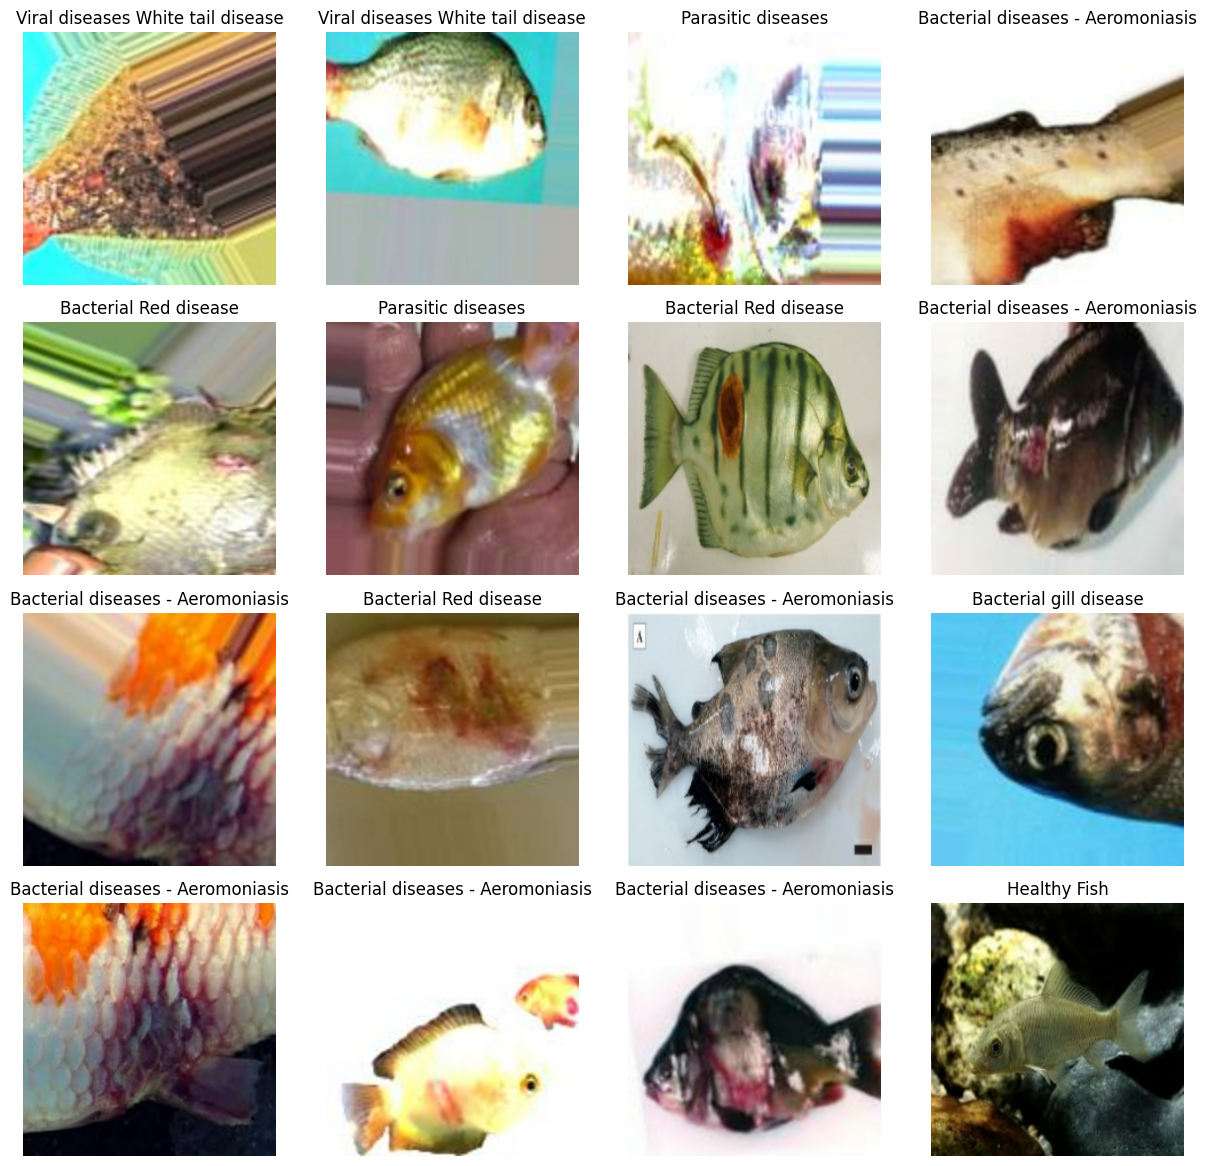

In [6]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Splitting Dataset into Training, Validation, and Testing

In [7]:
TRAIN_SIZE, VALIDATION_SIZE= 0.9, 0.1

In [8]:
train_batch = int(len(dataset) * TRAIN_SIZE)
train_ds = dataset.take(train_batch)

In [9]:
val_batch = int(len(dataset) * VALIDATION_SIZE)
validation_ds = dataset.skip(train_batch).take(val_batch)

# Building Model

## Resizing and Normalization Layer

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False

# Model
model = Sequential([
    base_model,
    Flatten(),
    Dense(384, activation='relu'),
    Dense(n_classes, activation='softmax') 
])


We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Creating a checkpoint to save the model with the best score.

In [15]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

## Training

In [16]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = validation_ds,
    verbose = 1,
    epochs = EPOCHS,
    callbacks = callback
)

Epoch 1/50


KeyboardInterrupt: 

## Loading Model

In [18]:
model = load_model('model.keras')

## Evaluation

In [ ]:
test_dataset = image_dataset_from_directory(
    PATH + 'Test/',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 697 files belonging to 7 classes.


### Predict

In [ ]:
all_predictions = []
all_labels = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

1/1 [==============================] - 1s 1s/step


### Metrices

In [ ]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9813486370157819
F1 Score:  0.9813959612729987
Recall:  0.9813486370157819
Precision:  0.9819536093199158


### Confusion Matrix

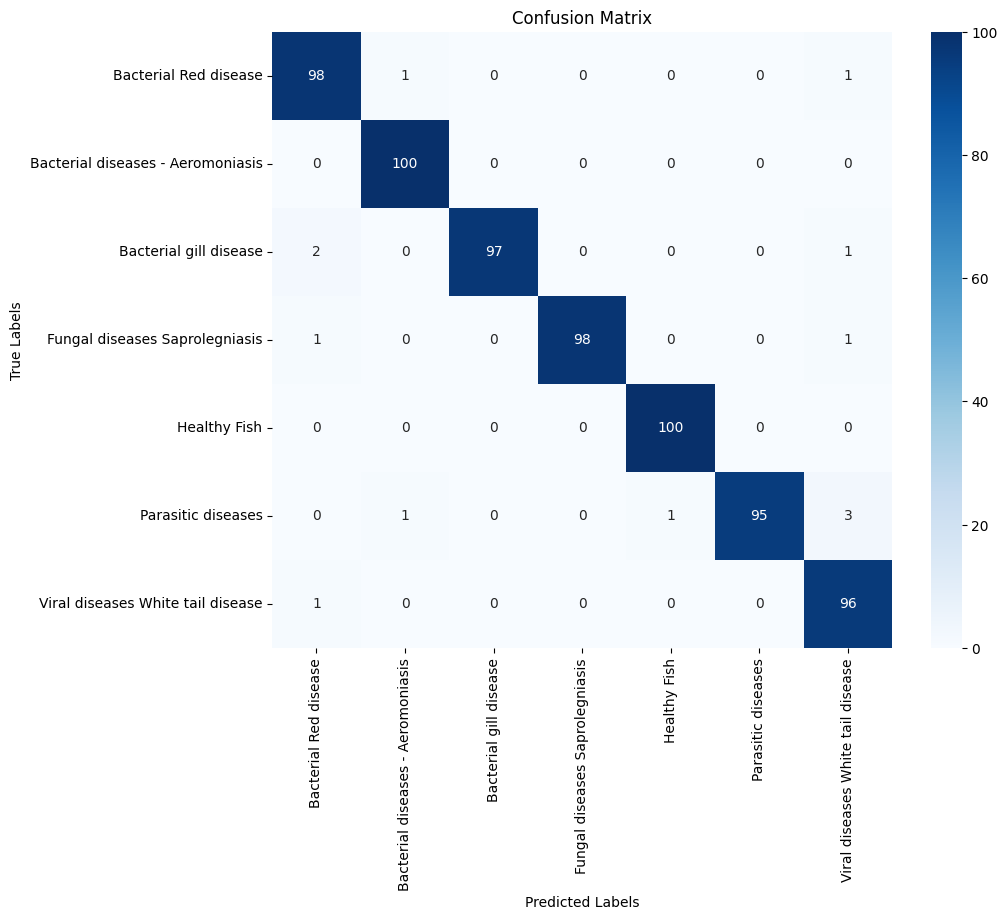

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


# Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

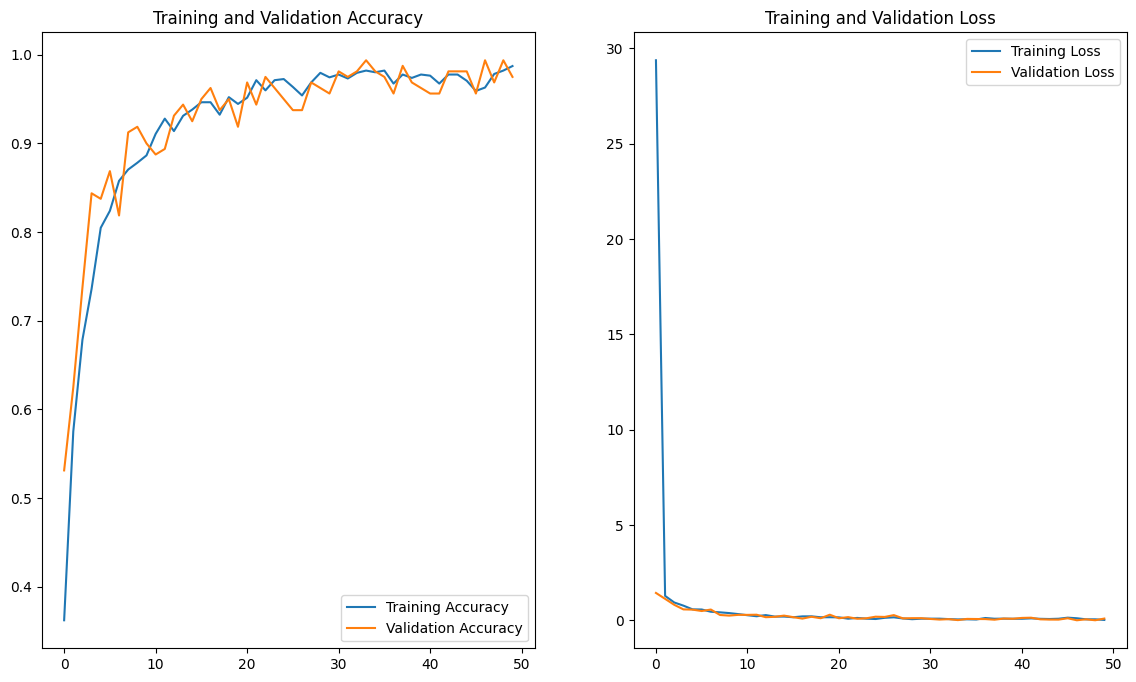

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('curves.png', dpi = 300)
plt.show()

# Inference



## Inference Function

In [ ]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Inference

1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

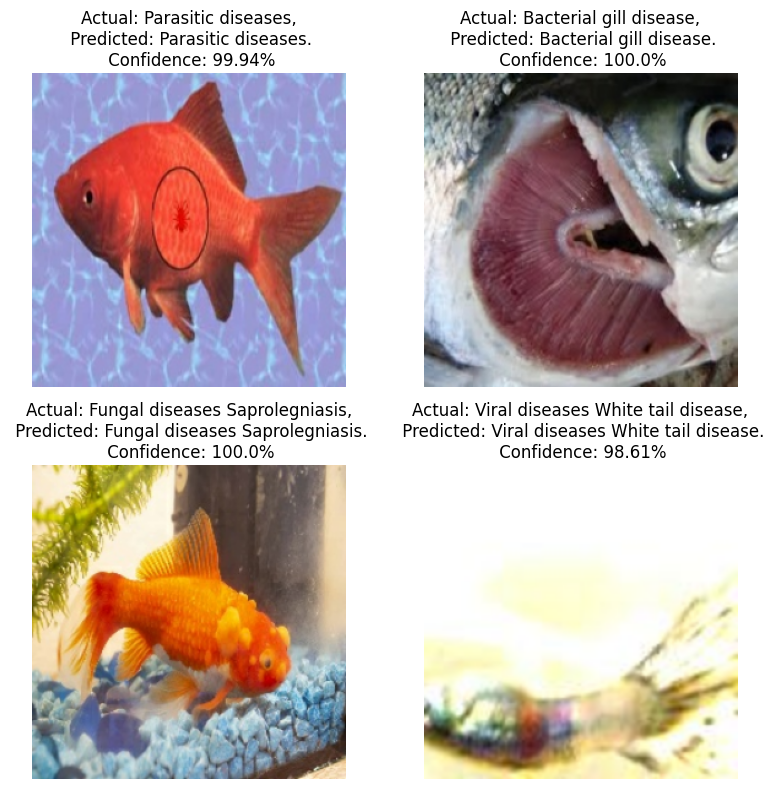

In [ ]:
plt.clf()
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(6):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i])
            actual_class = class_names[labels[i]]

            ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            ax.axis("off")
plt.tight_layout()
plt.show()


# Inference from File

In [19]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicted class: Bacterial Red disease


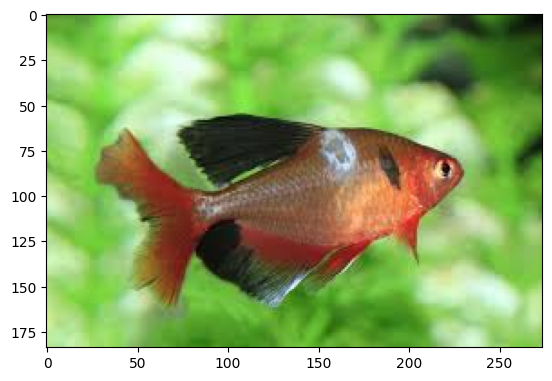

In [20]:
sample_predict(model, "C:/Users/shafe/Downloads/images (2).jpeg")